In [1]:
import warnings
warnings.filterwarnings('ignore')
import theano
theano.config.floatX = 'float64'
import theano.tensor as t
from theano.tensor.nlinalg import det

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
from pymc3.math import logsumexp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import scipy as sp
import numpy as np

import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('birth_data_train_n.csv')
df_train.head()
prem = lambda x: 0. if x / 7. > 36. else 1.
df_train.loc[:, 'gestation age'] = df_train['gestation age'].apply(prem)
df_train.head()

,Unnamed: 0,weight,length,head circumference,gestation age,mothers age,mothers income,mothers years of post-2nd edu
0,0,5.671598,35.511059,30.807990,1.0,19.0,48119.767546,5.0
1,1,2.736292,38.844446,28.546780,1.0,21.0,47964.303743,2.0
2,2,2.007545,41.351882,30.397939,1.0,19.0,48132.680505,4.0
3,3,3.716350,36.891095,25.626810,1.0,22.0,48073.686796,4.0
4,5,2.336969,39.484994,31.680547,1.0,22.0,48003.589748,4.0


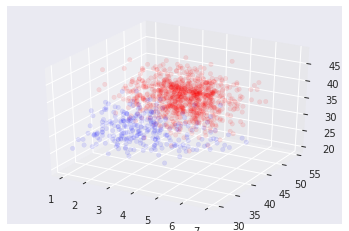

In [3]:
prem_df = df_train[df_train['gestation age'] == 1]
reg_df = df_train[df_train['gestation age'] == 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(prem_df['weight'].values, prem_df['length'].values, prem_df['head circumference'].values, color='b', alpha=0.1)
ax.scatter(reg_df['weight'].values, reg_df['length'].values, reg_df['head circumference'].values, color='r', alpha=0.1)
plt.show()

In [4]:
df_test = pd.read_csv('birth_data_test_n.csv')
df_test.head()
prem = lambda x: 0. if x / 7. > 36. else 1.
df_test.loc[:, 'gestation age'] = df_test['gestation age'].apply(prem)
df_test.head()

,Unnamed: 0,weight,length,head circumference,gestation age,mothers age,mothers income,mothers years of post-2nd edu
0,0,6.133074,48.826057,39.759585,0.0,22.0,49998.639713,3.0
1,1,2.547261,42.876142,36.083351,0.0,19.0,49956.664052,4.0
2,2,4.395539,40.078613,42.956421,0.0,20.0,49980.427018,3.0
3,3,2.788943,47.792807,42.615776,0.0,22.0,50057.775262,5.0
4,4,4.476369,44.304450,37.777845,0.0,21.0,49935.312928,3.0


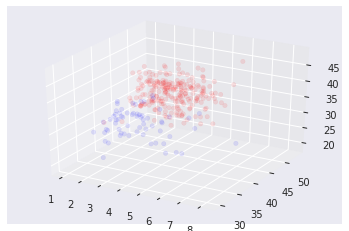

In [5]:
prem_df = df_test[df_test['gestation age'] == 1]
reg_df = df_test[df_test['gestation age'] == 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(prem_df['weight'].values, prem_df['length'].values, prem_df['head circumference'].values, color='b', alpha=0.1)
ax.scatter(reg_df['weight'].values, reg_df['length'].values, reg_df['head circumference'].values, color='r', alpha=0.1)
plt.show()

In [6]:
#covariates
train_cov = df_train[['mothers age', 'mothers income', 'mothers years of post-2nd edu']].values
covariates = t._shared(train_cov)

#training data
train_x = df_train[['weight', 'length', 'head circumference']].values
train_y = df_train['gestation age'].values
x_obs = t._shared(train_x)
n_samples = len(train_x)

#testing data
test_x = df_test[['weight', 'length', 'head circumference']].values
test_y = df_test['gestation age'].values

dim = train_x.shape[1]

In [7]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * t.log(2 * np.pi) + t.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau0, tau1):
    def logp_(value):
        logps = [t.log(pi[0]) + logp_normal(mus[0], tau0, value), 
                 t.log(pi[1]) + logp_normal(mus[1], tau1, value)]

        return t.sum(logsumexp(t.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model_1:
    
    sigma0 = pm.Uniform('sigma0', 0, 20, shape=dim)
    sigma1 = pm.Uniform('sigma1', 0, 20, shape=dim)
    
  
    sigma_diag0 = pm.Deterministic('cov0', t.nlinalg.diag(sigma0))
    tau0 = pm.Deterministic('tau0', t.nlinalg.matrix_inverse(sigma_diag0))
    
    sigma_diag1 = pm.Deterministic('cov1', t.nlinalg.diag(sigma1))
    tau1 = pm.Deterministic('tau1', t.nlinalg.matrix_inverse(sigma_diag1))
    
    
    mus = t.stack([MvNormal('mu_%d' % i, mu=np.zeros(3) + 5., tau=0.01 * np.eye(3), shape=(3,))
           for i in range(2)])
    pi = Dirichlet('pi', a=100 * np.ones(2), shape=(2,))
    
    xs = DensityDist('x', logp_gmix(mus, pi, tau0, tau1), observed=x_obs)

In [8]:
with model_1:
    start = find_MAP()
    step = pm.Metropolis()
    trace = sample(100000, step=step)

Optimization terminated successfully.
         Current function value: 8362.114249
         Iterations: 110
         Function evaluations: 172
         Gradient evaluations: 172


100%|██████████| 100000/100000 [05:45<00:00, 289.69it/s]


In [9]:
start

{'mu_0': array([  3.87798117,  44.65375353,  37.64367962]),
 'mu_1': array([  3.10160979,  40.87198855,  29.49630504]),
 'pi_stickbreaking_': array([ 0.62871983]),
 'sigma0_interval_': array([-3.01887253, -0.48250947,  0.20858633]),
 'sigma1_interval_': array([-2.44574641,  1.59538224,  0.09877115])}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f8df13550>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f8c4994a8>]], dtype=object)

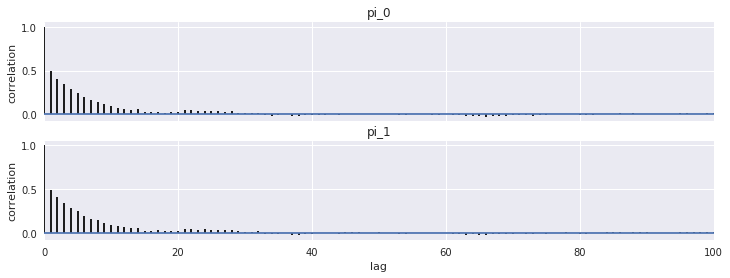

In [10]:
pm.autocorrplot(trace[10000::10], varnames=['pi'])

In [11]:
pm.stats.waic(trace[10000::10], model_1)

(16629.877812407969, 0.0)

In [12]:
pi_1 = trace['pi'][10000::10][:, 1].mean()

pi_0 = trace['pi'][10000::10][:, 0].mean()
sigma_0 = trace['sigma0'][10000::10].mean(axis=0)
sigma_1 =trace['sigma1'][10000::10].mean(axis=0)

mu_0 = trace['mu_0'][10000::10].mean(axis=0)

mu_1 = trace['mu_1'][10000::10].mean(axis=0)

def label(sigma_0, sigma_1, mu_0, mu_1, pi_0, pi_1, x):
    
    cov_0 = np.diag(sigma_0)
    cl_0 = sp.stats.multivariate_normal(mu_0, cov_0) 

    cov_1 = np.diag(sigma_1)
    cl_1 = sp.stats.multivariate_normal(mu_1, cov_1) 
    
    p0 = cl_0.pdf(x) * pi_0
    p1 = cl_1.pdf(x) * pi_1
    l = np.argmax(np.vstack((p0, p1)).T, axis=1)

    return l

post = label(sigma_0, sigma_1, mu_0, mu_1, pi_0, pi_1, train_x)
print('train error posterior:',1- abs(post - train_y).sum() / len(train_y))

train error posterior: 0.0940170940171


In [13]:
print('actual percent of 1:', train_y.sum()/len(train_y))

actual percent of 1: 0.230769230769


In [14]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(train_x)
diff = ((kmeans.labels_) - train_y)
print ('error rate train kmeans: ', len(diff[diff != 0]) * 1./ len(df_train))

error rate train kmeans:  0.13760683760683762


In [15]:
diff = (( kmeans.predict(test_x)) - test_y)
print ('error rate test kmeans: ', len(diff[diff != 0]) * 1./ len(df_test))

error rate test kmeans:  0.16666666666666666


In [17]:
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(train_x)
diff = train_y - (gmm.predict(train_x))
print ('error rate train mle: ', 1- len(diff[diff != 0]) * 1. / len(df_train))

error rate train mle:  0.11880341880341883


In [19]:
diff = test_y - (gmm.predict(test_x))
print ('error rate test mle: ', 1- len(diff[diff != 0]) * 1. / len(df_test))

error rate test mle:  0.1394557823129252


In [20]:
post = label(sigma_0, sigma_1, mu_0, mu_1, pi_0, pi_1, test_x)
print('test error posterior:', 1 - abs(post - test_y).sum() / len(test_y))

test error posterior: 0.12925170068
